<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico I - Estadística </h1>
<h3> Análisis y Visualización de Datos - 2019 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10. Usaremos una [versión ya limpia del dataset](https://www.kaggle.com/gsutters/the-human-freedom-index/home) que pueden descargar desde Kaggle.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con dos estimadores principales: *hf_score* que hace referencia a Human Freedom, y *ef_score* que hace referencia a Economic Freedom. Estos dos estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn as sb
from scipy import stats

In [2]:
sb.__version__

'0.9.0'

In [3]:
dataset = pandas.read_csv('hfi_cc_2018.csv')
dataset.shape

(1458, 123)

In [4]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'pf_rol_procedural',
       'pf_rol_civil', 'pf_rol_criminal', 'pf_rol', 'pf_ss_homicide',
       'pf_ss_disappearances_disap',
       ...
       'ef_regulation_business_bribes', 'ef_regulation_business_licensing',
       'ef_regulation_business_compliance', 'ef_regulation_business',
       'ef_regulation', 'ef_score', 'ef_rank', 'hf_score', 'hf_rank',
       'hf_quartile'],
      dtype='object', length=123)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [5]:
important_cols = ['year', 'ISO_code', 'countries', 'region']

num_cols = [col for col in dataset.columns if 'pf_identity' in col]

num_cols += [
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

important_cols += num_cols

## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.
  2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. ¿Tiene sentido calcular la moda? 
  3. ¿Son todos los valores de *pf_identity*  y *hf_score* directamente comparables? ¿Qué otra variable podría influenciarlos?
  4. ¿Cómo pueden sanearse los valores faltantes?
  5. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? ¿Los outliers, son globales o por grupo? ¿Los eliminaría del conjunto de datos?
  
  

### 1. Calcular el rango de las variables


In [6]:
ds = dataset[important_cols]
num_cols += ['year']
num_ds = dataset[num_cols]
num_ds = num_ds.fillna(5)
ranges = []
for col in num_cols:
    ranges.append({ 
        'Rango': num_ds[col].max() - num_ds[col].min(), 
        'Features': col})

ranges_df = pandas.DataFrame(ranges)
ranges_df

Features       Rango
0               pf_identity_legal   10.000000
1   pf_identity_parental_marriage   10.000000
2    pf_identity_parental_divorce   10.000000
3            pf_identity_parental   10.000000
4            pf_identity_sex_male   10.000000
5          pf_identity_sex_female   10.000000
6                 pf_identity_sex   10.000000
7             pf_identity_divorce   10.000000
8                     pf_identity   10.000000
9                        ef_score    6.310000
10                        ef_rank  161.000000
11                       hf_score    5.360486
12                        hf_rank  161.000000
13                           year    8.000000

En este nuevo dataframe que hemos creado, guardamos el rango de las variables numéricas, incluído el año.
Notamos que todas las variables que miden puntaje van del 0 al 10, lo que implica que se han registrado valores para estos índices de personal freedom tanto de 0 como de 10 en ciertos países.
Los puntajes finales ya calculados sí muestran un rango más acotado: el rango de ef_score es de 6.31 y el de hf_score de 5.36, de lo que podemos deducir que no hay scores extremadamente altos y extremadamente bajos simultáneamente a través de los países.
El rango de los rankings tiene sentido considerando que estamos puntuando un grupo de 162 países, y el del año condice con la información del reporte de que el estudio lleva ya 8 años (2008-2016) de continuidad.


### 2. Estadísticos de pf_identity y hf_score globales

In [8]:
pf_hf_global = dataset[['pf_identity', 'hf_score']]
pf_hf_global.describe()


pf_identity     hf_score
count  1378.000000  1378.000000
mean      7.334180     6.993444
std       3.159473     1.025811
min       0.000000     3.765827
25%       5.000000     6.336685
50%       9.166667     6.923840
75%      10.000000     7.894660
max      10.000000     9.126313

### 2. Estadísticos de pf_identity y hf_score en Latinoamérica y el caribe

In [9]:
pf_hf_lat = ds.loc[ds['region'] == 'Latin America & the Caribbean']
pf_hf_lat = pf_hf_lat[['pf_identity', 'hf_score']]

pf_hf_lat.describe()

pf_identity    hf_score
count   232.000000  232.000000
mean      8.765086    7.047982
std       1.711732    0.608904
min       5.000000    4.200724
25%       7.500000    6.779311
50%      10.000000    7.028045
75%      10.000000    7.339903
max      10.000000    8.290152

Comparando los estadísticos de ambos conjuntos de países, podemos llegar a las siguientes conclusiones:
Como región, Latinoamérica sube la **media** de ambos puntajes con respecto al conjunto global. Implica que en la región hay uno o más países cuyas leyes sobre identidad, sexualidad y matrimonio garantizan mayores libertades individuales que el promedio del resto del mundo. Que el **hf_score** sea más alto podría tener que ver con lo anterior, o que tal vez este puntaje mayor que la media resulte también de otro tipo de libertades que están más presentes en la región.

Una **desviación** menor en Latinoamérica y el Caribe habla de un poco más de *homogeneidad* entre los puntajes, lo que tiene sentido pues no sólo compartimos una zona geográfica sino también muchos rasgos culturales y fenómenos sociales, también afectados por la cercanía. 

Al estudiar las variaciones entre **mínimo y máximo** para cada variable, encontramos que como región nos situamos en la mitad "más libre" del mundo en cuanto a libertades individuales relacionadas a la identidad. Sin embargo, no estamos tan alejados del fondo de la lista si hablamos del puntaje de libertad humana final, lo que puede llevarnos a concluir varias cosas, como que no pudiésemos considerarnos tan libres respecto a otros factores (otras libertades personales o libertades económicas) o considerar la posibilidad de ciertos *outliers* dentro de la región.

Esta última idea sobre el hf_score se refuerza cuando analizamos los **cuartiles** y se observa que ya dentro del primer cuartil (25%) ya se encuentran puntajes de casi 7 y nos mantenemos por encima de este valor en el resto de los cuartiles.

Por último, no tiene sentido calcular la moda en este caso ya que nos encontramos con una distribución bimodal, como veremos más adelante, asi que no es significativo.

### 3. ¿Son todos los valores de pf_identity y hf_score directamente comparables?

No, principalmente por el hecho de que el puntaje de **Human Freedom**, el final, se compone de la media entre muchísimos factores de distinta índole, dentro de los cuales se encuentran todas las variables que forman parte de pf_identity, como también todos los factores relacionados a lo económico u otras libertades personales con distintos criterios (aplicación de las leyes, supervivencia, movilidad, etc.)

### 4. ¿Cómo pueden sanearse los valores faltantes?

Para facilitar el cálculo de los rangos, escogimos reemplazar los valores vacíos *NaN*(no numéricos) con 5, con la idea de ensuciar lo menos posible el resultado. En otros casos no fue necesario pues se saltean por default, y nos pareció mejor dejarlos como estaban para no introducir más ruido al análisis.

### 5. Outliers

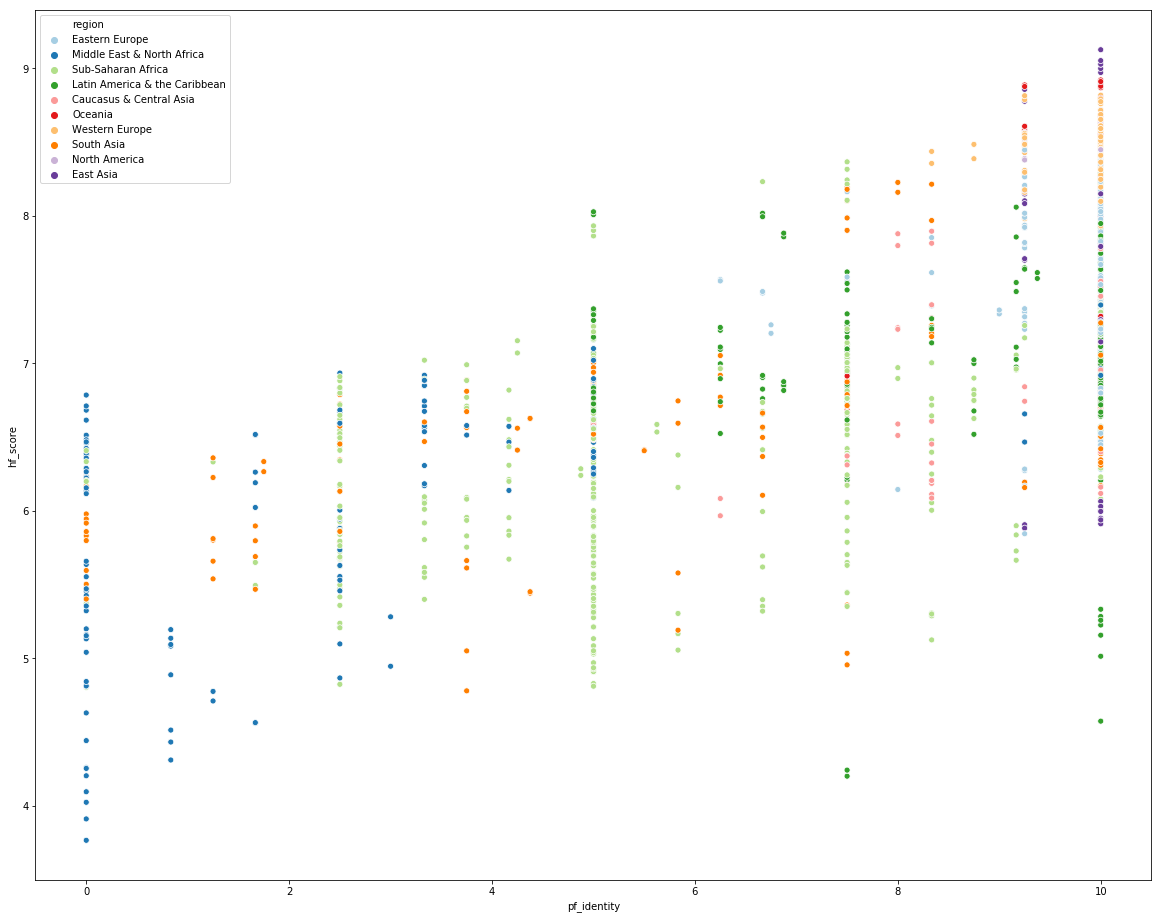

In [10]:
pf_hf_global = dataset[['pf_identity', 'hf_score','countries','region']]
dims = (20, 16)
fig, ax = plt.subplots(figsize=dims)
sb.scatterplot(ax=ax, 
               x='pf_identity', 
               y='hf_score', 
               data=pf_hf_global, 
               hue='region', 
               x_jitter=True,  
               y_jitter=True, 
               palette=sb.color_palette("Paired",10))


Con un gráfico de **scatterplot** podemos realizar un primer paneo en busca de outliers, tomando los valores que visualmente se alejan más de la tendencia general. Aquí lo que resulta interesante es que podemos destacar ciertos puntos que se alejan notablemente de la media, y gracias a la agrupación por región, vemos que pertenecen en su mayoría a **Latinoamérica y el Caribe**, lo que refuerza nuestra hipótesis de valores raros dentro de ésta.

No podemos generalizar al punto de decir que cualquier outlier dentro de un grupo será también un outlier global, o viceversa, aunque es más probable que si es un outlier para el conjunto total, probablemente también lo sea para su subconjunto (región).

Dentro del contexto de este análisis, no tiene ningún sentido eliminar un outlier pues proveen información muy valiosa al momento de sacar conclusiones. Por ejemplo, un país que rankee muy alto en personal freedom pero excesivamente bajo en economic freedom no se considera un error de medición, sino un fenómeno muy interesante y que espera un análisis más profundo.

## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.
2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?
3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?

Hint: hay un gráfico de seaborn que hace todo por vos!

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

(0, 11)

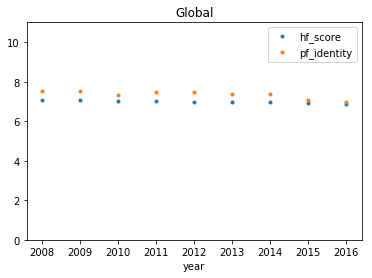

In [124]:
# 1_
pf_hf_global_yearly = dataset[['year', 'pf_identity', 'hf_score']]
pv = pandas.pivot_table(pf_hf_global_yearly.dropna(), index=["year"], values=['pf_identity', 'hf_score'])
axs=pv.plot(style='.', title="Global")
axs.set_ylim(0,11)


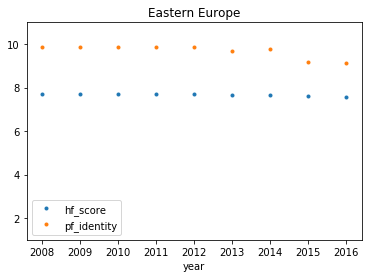

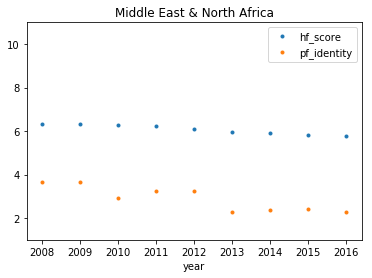

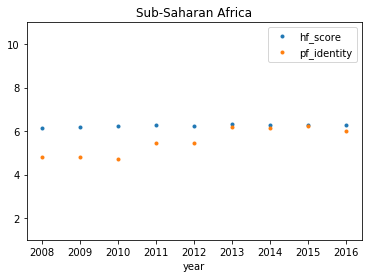

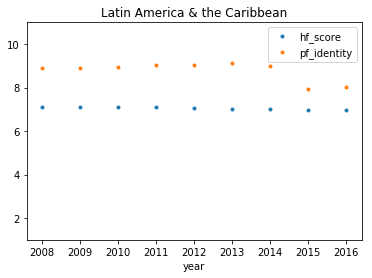

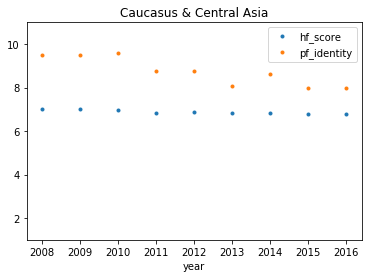

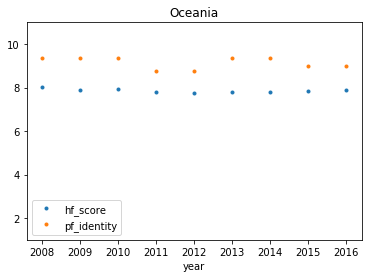

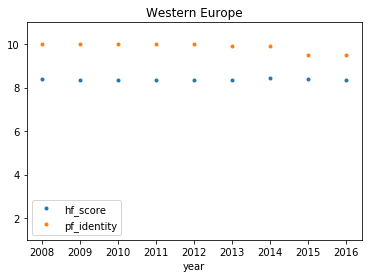

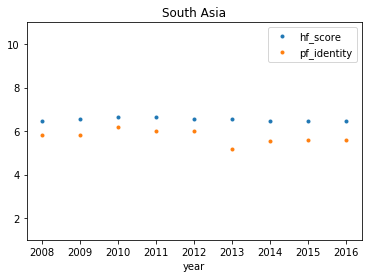

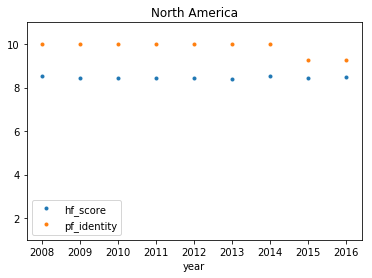

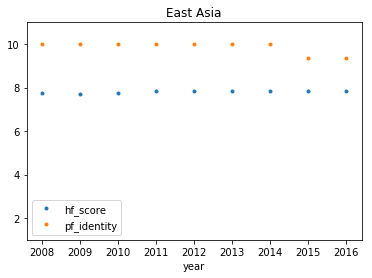

In [96]:
# 2_ ¿La tendencia observada, es la misma que si no dividimos por regiones?
#     Se ve una gran separacion de la media regional respecto a la global, lo
# que si sigue teniendo buena correspondencia a ojo, es el paralelismo que
# estos dos indicadores tienen. La tendecia no es la misma, al menos en tres
# sentidos: distancia entre puntos, media, y valor(con valor me refiero a quien
# suele estar arriba de quien).
pf_hf_region_yearly = dataset[['year', 'region', 'pf_identity', 'hf_score']]
gb=pf_hf_region_yearly
for reg in gb['region'].unique():
    gbregion = gb[gb.region==reg]
    pandas.pivot_table(gbregion.dropna(), index=['year'],
                       values=['pf_identity', 'hf_score']).plot(style='.', title=reg).set_ylim(1,11)



/home/bananopc/anaconda3/envs/diplodatos/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


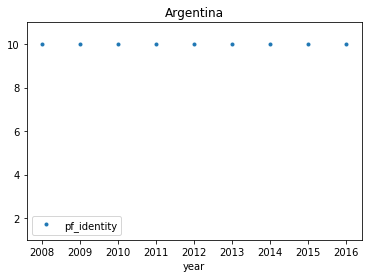

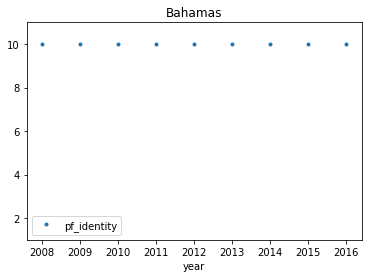

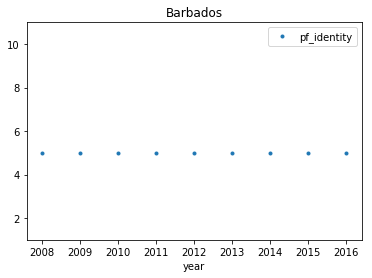

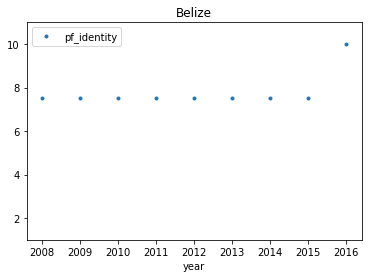

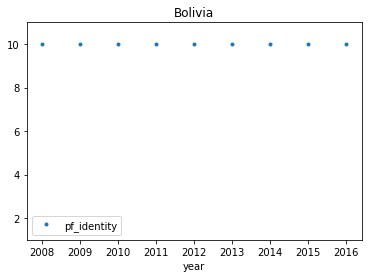

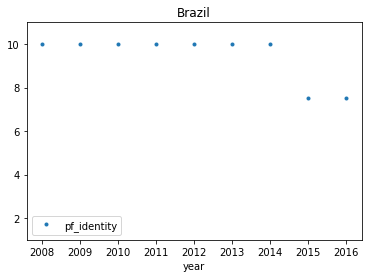

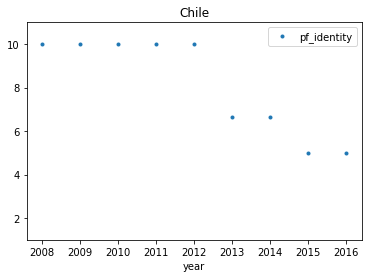

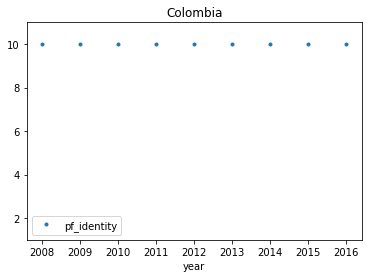

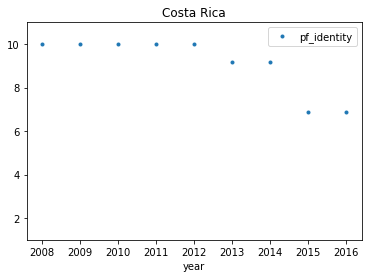

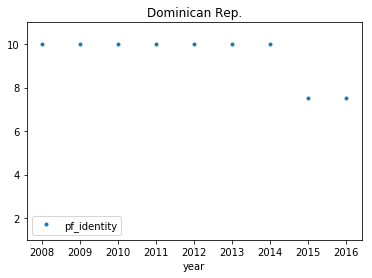

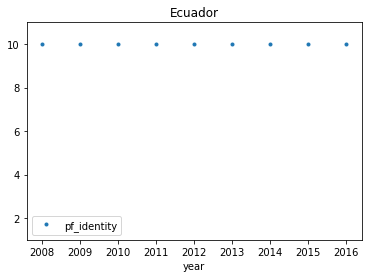

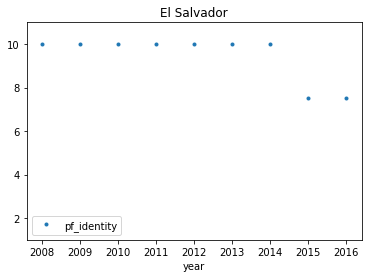

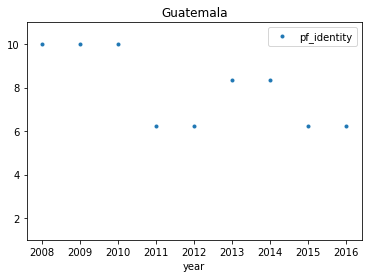

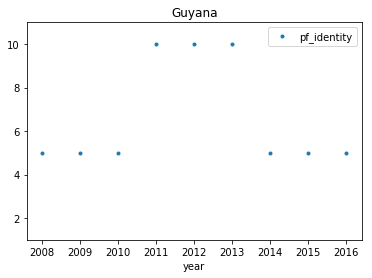

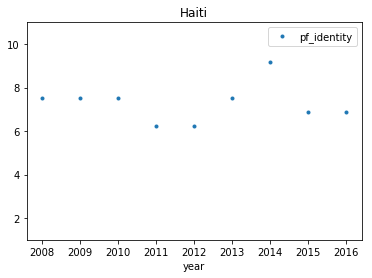

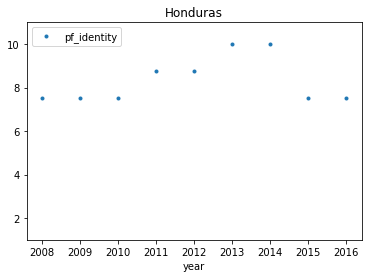

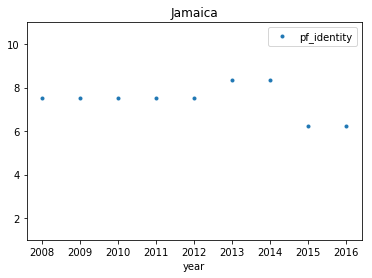

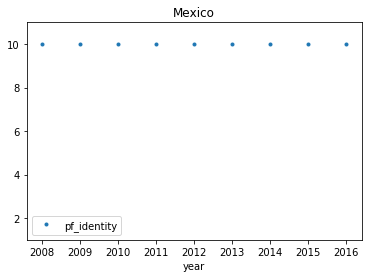

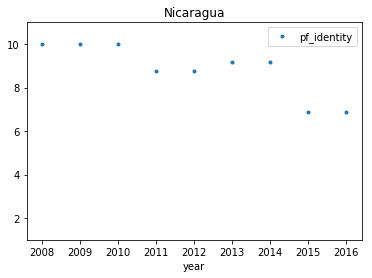

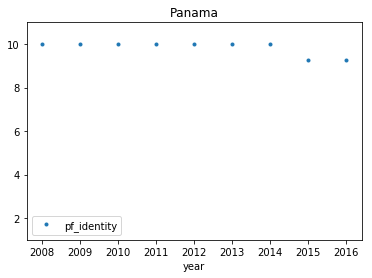

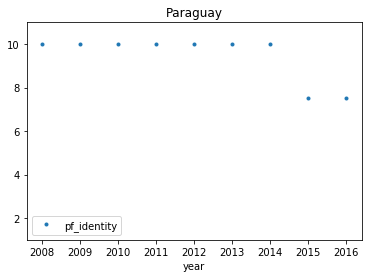

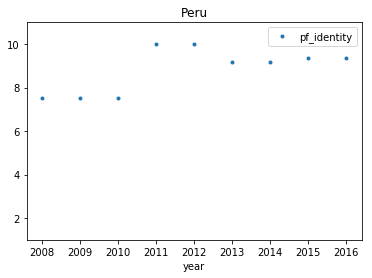

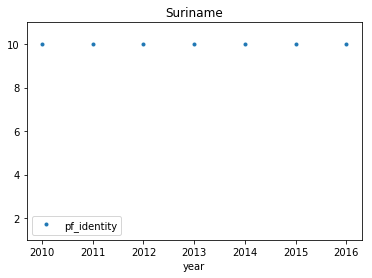

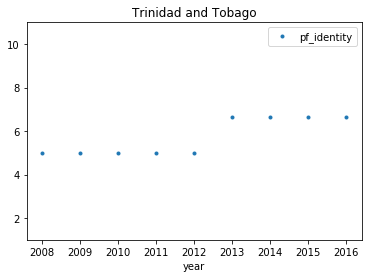

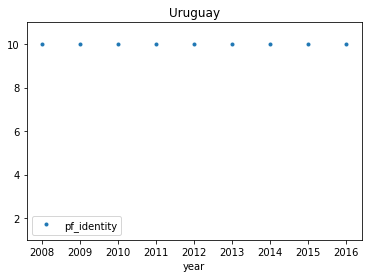

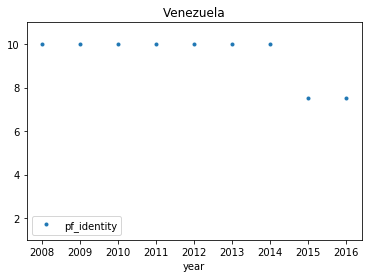

In [121]:
# Los mas relevantes a la tendencia son aquello que no siguen
# tendencias sinusoidales, que podrian verse como situaciones
# locales que no agregan a una mirada tendencista continental.
pf_countries_yearly = dataset[['year', 'countries', 'region', 'pf_identity']]
pf_reg=pf_countries_yearly[pf_countries_yearly.region=='Latin America & the Caribbean']

for lat in pf_reg['countries'].dropna().unique():
    pf_lat = pf_reg[pf_reg.countries==lat]
    pandas.pivot_table(pf_lat.dropna(), index=['year'],
                       values=['pf_identity']).plot(style='.', title=lat).set_ylim(1,11)


(0, 11)

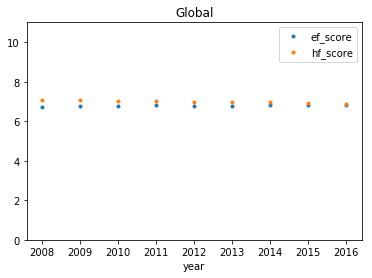

In [125]:
# Despues del punto anterior, parece tener cierta correlacion
# pero habria que analizar region a region, pais a pais,con 
# mayor granularidad para ver si no es una coincidencia.
hf_ef_global_yearly = dataset[['year', 'hf_score', 'ef_score']]
pv = pandas.pivot_table(hf_ef_global_yearly.dropna(), index=["year"], values=['ef_score', 'hf_score'])
axs=pv.plot(style='.', title="Global")
axs.set_ylim(0,11)

## 3. Distribuciones
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos los registros para esas zonas en estos gráficos?
  2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.
  3. Realizar un gráfico QQ de las mismas distribuciones. Se puede utilizar a,bas distribuciones sobre todos los datos o sólo sobre Latinoamérica, pero no cruzadas.
  4. Medir la asimetría (skew) y curtosis de las mismas distribuciones con las que realizó el gráfico anterior. ¿Cómo se relacionan estos estadísticos con la forma del gráfico QQ obtenido previamente? ¿El gráfico QQ provee más información que no esté presente en estos estadísticos?

### Ejercicio 1


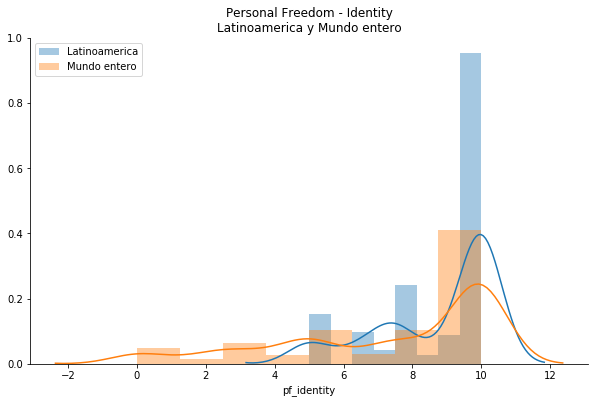

In [36]:
datos_latinoamerica = dataset[dataset['region'] == 'Latin America & the Caribbean']

plt.figure(figsize=(10,6))
ax = sb.distplot(datos_latinoamerica['pf_identity'].dropna(), bins = 8, label='Latinoamerica')
sb.distplot(dataset['pf_identity'].dropna(), bins = 8, label='Mundo entero')
plt.legend()
ax.set_title("Personal Freedom - Identity\nLatinoamerica y Mundo entero")
sb.despine()

*En cuanto a esta distribución notamos que tiene un claro sesgo hacia la derecha, más en 
Latinoamerica que en el resto del mundo.*

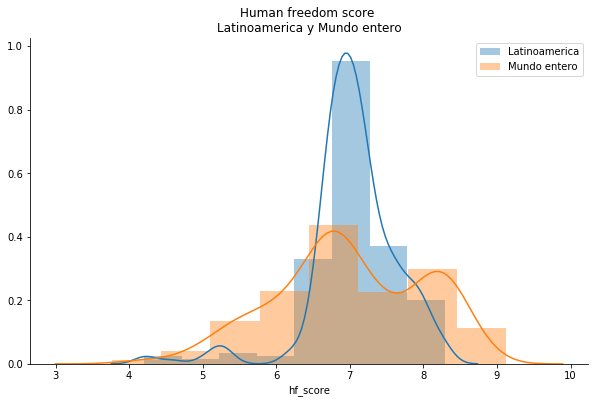

In [37]:
# Hf_score
plt.figure(figsize=(10,6))
ax = sb.distplot(datos_latinoamerica['hf_score'].dropna(), bins = 8, label='Latinoamerica')
sb.distplot(dataset['hf_score'].dropna(), bins = 8, label='Mundo entero')
plt.legend()
ax.set_title("Human freedom score \nLatinoamerica y Mundo entero")
sb.despine()

*Esta distribucion se aproxima mucho a una normal, sobretodo en Latinoamerica. En el resto
del mundo podemos ver que tiene tendencias modales, en aproximadamente 6.5 y 8.5*

### Ejercicio 2
Para hacer este ejercicio primero tenemos que normalizar la distribución (dividir por media y DE).


In [38]:
media_lat_hf = datos_latinoamerica['hf_score'].dropna().mean()
std_lat_hf = datos_latinoamerica['hf_score'].dropna().std()
norm_datos_latinoamerica = ((datos_latinoamerica['hf_score'].dropna())-media_lat_hf)/std_lat_hf 
stats.kstest(norm_datos_latinoamerica,'norm')

KstestResult(statistic=0.1504746027707088, pvalue=4.737935317381503e-05)

*No podemos afirmar que se trate de una distribución normal*

### Ejercicio 3
Vamos a realizar un grafico QQ sobre las mediciones en Latinoamérica para comparar hf_score y ef_score con
una distribución normal

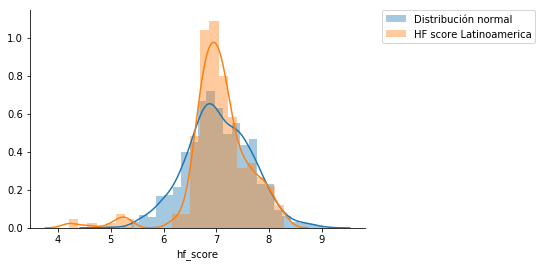

In [39]:
loc_hf, scale_hf = stats.norm.fit(datos_latinoamerica['hf_score'].dropna())
norm_dist_hf = stats.norm(loc_hf, scale_hf)
# Generamos una muestra
sample_hf = norm_dist_hf.rvs(1000)
# La graficamos
sb.distplot(sample_hf, label='Distribución normal')
sb.distplot(datos_latinoamerica['hf_score'].dropna(), label='HF score Latinoamerica')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sb.despine()


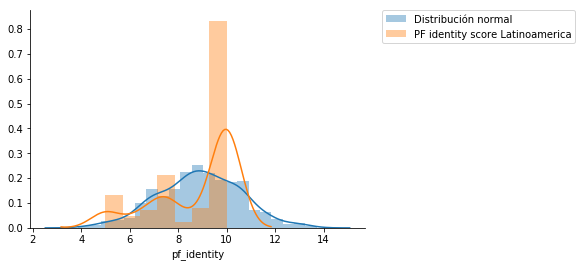

In [40]:
loc_pfid, scale_pfid = stats.norm.fit(datos_latinoamerica['pf_identity'].dropna())

norm_dist_hf = stats.norm(loc_hf, scale_hf)
norm_dist_pfid = stats.norm(loc_pfid, scale_pfid)
sample_pfid = norm_dist_pfid.rvs(1000)

sb.distplot(sample_pfid, label='Distribución normal')
sb.distplot(datos_latinoamerica['pf_identity'].dropna(), label='PF identity score Latinoamerica')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sb.despine()


### Conclusión
Si bien el gráfico de hf_score se parece un poco mas a una distribución normal, ninguna
de las dos es lo suficientemente parecido. De todas formas, no podemos concluir nada
demasiado confiable sólo visualmente, por lo que haremos un gráfico QQ.

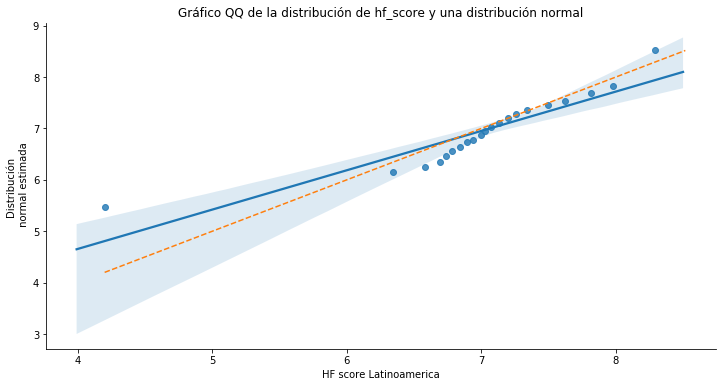

In [41]:
percs = numpy.linspace(0,100,21)  # Creamos 20 puntos percentiles igualmente distribuidos entre 0 y 100.
qn_sample_hf = numpy.percentile(datos_latinoamerica['hf_score'].dropna(), percs)
qn_norm_dist_hf = numpy.percentile(norm_dist_hf.rvs(len(datos_latinoamerica['hf_score'].dropna())), percs)

plt.figure(figsize=(12,6))
sb.regplot(x=qn_sample_hf, y=qn_norm_dist_hf)
plt.xlabel('HF score Latinoamerica')
plt.ylabel('Distribución \n normal estimada')
plt.title('Gráfico QQ de la distribución de hf_score y una distribución normal')

x = numpy.linspace(numpy.min((qn_sample_hf.min(), qn_norm_dist_hf.min())), numpy.max((qn_sample_hf.max(),qn_norm_dist_hf.max())))
plt.plot(x,x,ls="--")

sb.despine()

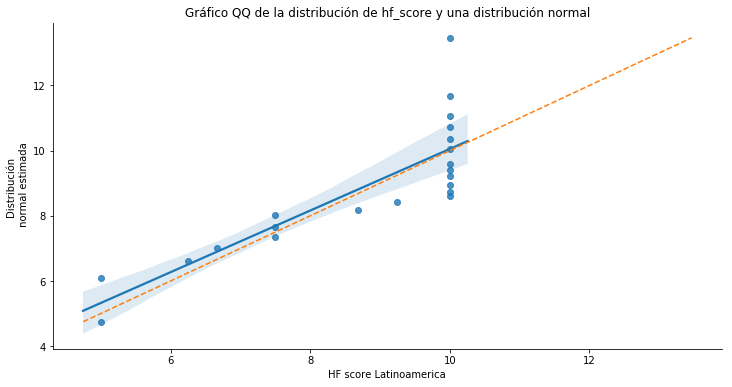

In [42]:
qn_sample_pfid = numpy.percentile(datos_latinoamerica['pf_identity'].dropna(), percs)
qn_norm_dist_pfid = numpy.percentile(norm_dist_pfid.rvs(len(datos_latinoamerica['pf_identity'].dropna())), percs)

plt.figure(figsize=(12,6))
sb.regplot(x=qn_sample_pfid, y=qn_norm_dist_pfid)
plt.xlabel('HF score Latinoamerica')
plt.ylabel('Distribución \n normal estimada')
plt.title('Gráfico QQ de la distribución de hf_score y una distribución normal')

x = numpy.linspace(numpy.min((qn_sample_pfid.min(), qn_norm_dist_pfid.min())), numpy.max((qn_sample_pfid.max(),qn_norm_dist_pfid.max())))
plt.plot(x,x,ls="--")

sb.despine()

### Conclusiones graficos QQ
Aqui podemos ver claramente como ninguna de las distribuciones es exactamentenormal, si bien hf_score se parece bastante a una normal


### Ejercicio 4


In [43]:
print('Asimetria para HFSCORE = ',stats.skew(datos_latinoamerica['hf_score'].dropna()))
print('Asimetria para PFIdentity = ',stats.skew(datos_latinoamerica['pf_identity'].dropna()))


Asimetria para HFSCORE =  -1.442092151332142
Asimetria para PFIdentity =  -1.0478440216224703


*Los valores de la asimetria coinciden con el sesgo negativo que podemos observar
en los gráficos de hf y pfidentity scores*

## 4. Correlaciones

En este ejercicio queremos responder a las preguntas

* Las libertades sociales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades individuales y respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, hf_score y ef_score. 

Como pf_indentity contribuye al cálculo de hf_score y ef_score, esperamos hallar algún grado de correlación. Sin embargo, queremos medir qué tanta correlación. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación entre pf_identity y hf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en efecto, discreta.
3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 
4. [Opcional] Analizar la correlación entre la region y el hf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros)


### 1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? 
### ¿Es adecuado para los valores de pf_identity? ¿Por qué?

/anaconda3/envs/diplodatos/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/diplodatos/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


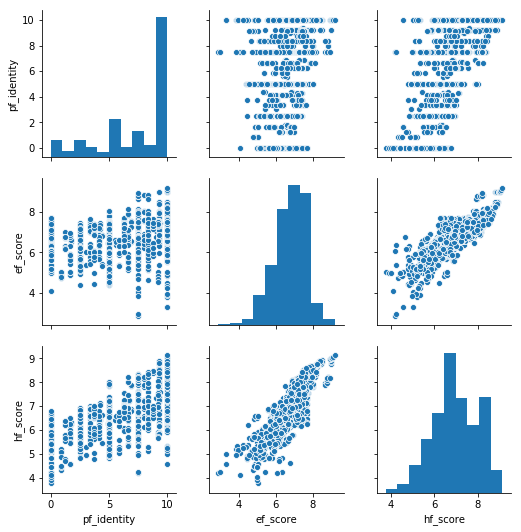

In [44]:
#PAIRPLOT de pf_identity, ef_score y hf_score

corr_data = dataset[['pf_identity', 'ef_score', 'hf_score']]

corr_data = corr_data.fillna(method='ffill', limit=2)

sb.pairplot(data=corr_data, kind='scatter')



Este gráfico combinado nos permite deducir que hay una **cierta correlación positiva entre ef_score y hf_score**, lo que conceptualmente es evidente si tenemos en cuenta que el ef_score cuenta con la mitad del peso total del promedio para calcular el hf_score. Esto sólo lo confirma.
Con respecto a **pf_identity**, vemos que se podría deducir del gráfico **algún grado de correlación con hf_score**(también obvio si consideramos su rol del primero en el cálculo del otro), pero no una correlación visual notoria entre ésta y ef_score.

Vale aclarar que la elección de este gráfico para **variables discretas** como pf_identity no resulta en el mejor impacto visual o en una buena intuición de la relación entre las variables.

### 2a. Correlación entre pf_identity y hf_score

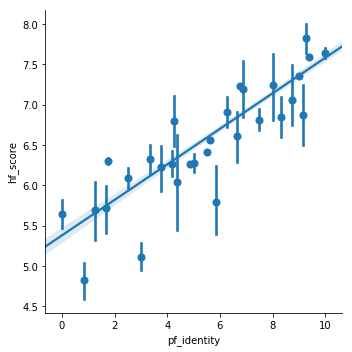

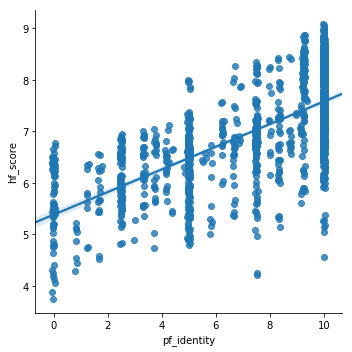

In [45]:

pf_hf = dataset[['pf_identity', 'hf_score']]

#con estimador
sb.lmplot(x="pf_identity", y="hf_score", data=pf_hf, x_estimator=np.mean)

#con jitter
sb.lmplot(x="pf_identity", y="hf_score", data=pf_hf, x_jitter=.05, y_jitter=.05)


Podemos notar una tendencia visual de correlación positiva cuando observamos que la mayoría de los puntos se sitúan cercanos a una recta de pendiente positiva no tan alejada de los 45 grados.

Adjuntamos dos gráficos, un pairplot normal y otro con estimadores de la media. Resulta más intuitivo el último cuando podemos notar gráficamente cuánto la media se aleja de la recta determinada por la correlación.

### 2b. Correlación entre pf_identity y ef_score

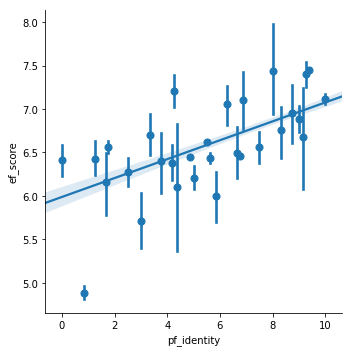

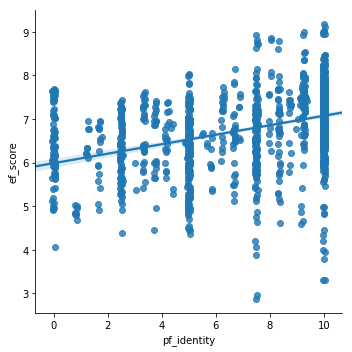

In [46]:

pf_ef = dataset[['pf_identity', 'ef_score']]
pf_ef.corr()

#con estimador
sb.lmplot(x="pf_identity", y="ef_score", data=pf_ef, x_estimator=np.mean)

#con jitter
sb.lmplot(x="pf_identity", y="ef_score", data=pf_ef, x_jitter=.05, y_jitter=.05)



En este caso se hace más evidente la distancia entre los puntos (y medias estimadas) y la recta que da la dirección de la correlación, que en este caso tiene una pendiente menor.

Esto deviene en una correlación visual menor y, probablemente, un coeficiente de correlación menor, también.
Los resultados anteriores pueden atribuirse al hecho de que pf_identity no conforma el cálculo de ef_score (la primera serie de variables refieren a libertades personales relacionadas a la identidad, el género y la familia, mientras que el índice ef apunta a factores exclusivamente económicos). Si bien ningún fenómeno dentro de un país puede considerarse aisladamente, los datos demuestran que no siempre estos dos factores en particular (identidad y economía) van de la mano.

### 3. Coeficientes de correlación

In [53]:
print('Indice de CORRELACIÓN Spearman')
print(pf_hf.corr(method = 'spearman'))
print(pf_ef.corr(method='spearman'))

Indice de CORRELACIÓN Spearman
             pf_identity  hf_score
pf_identity     1.000000  0.686109
hf_score        0.686109  1.000000
             pf_identity  ef_score
pf_identity     1.000000  0.426993
ef_score        0.426993  1.000000


Aunque no hayamos podido probar la normalidad de estas variables, sabemos que hay una homogeneidad entre ellas y, especificamente entre pf_identity y hf_score, una relación lineal. Podríamos confiar en el coeficiente Spearman, que nos da una correlación bastante fuerte en el primer caso, 0.68.
Para ef_score y pf_identity, el valor que observamos es un poco más bajo, una correlación media, lo que confirma la hipótesis de que no es una relación tan directa, tal como lo mostraba el gráfico anterior de scatteroplot. 

### 4. Correlación entre la region y el hf_score

In [54]:

pf_identity = dataset['pf_identity'].dropna()

hf_score = dataset['hf_score'].dropna()

region = dataset['region']

pf_stats = stats.f_oneway(pf_identity[region == 'Eastern Europe'], 
               pf_identity[region == 'Middle East & North Africa'],
               pf_identity[region == 'Sub-Saharan Africa'],
               pf_identity[region == 'Oceania'],
               pf_identity[region == 'Western Europe'],
               pf_identity[region == 'Latin America & the Caribbean'],
               pf_identity[region == 'Caucasus & Central Asia'],
               pf_identity[region == 'South Asia']
              )
print("Correlación entre la region y el puntaje Human Freedom")
print("F-value:", pf_stats.statistic)
print("P-value:", pf_stats.pvalue)



Correlación entre la region y el puntaje Human Freedom
F-value: 222.91589404165396
P-value: 2.2206017236163114e-217


Hallar la correlación entre variables categóricas y numéricas continuas es complicado, pero hay ciertas técnicas de comparación que pueden ser útiles siempre que se verifique su confiabilidad con otros test post-hoc.

En este caso, estamos usando **ANOVA** *(Análisis de Varianza)*, que se utiliza para comparar las medias de una condición a través de varios grupos (en nuestro caso, la pf_identity o hf_score a través de las regiones). Es decir, busca hallar un patrón transversal a las regiones que considere diferente, pero no informa sobre dónde está la diferencia.

Podemos usarlo bajo la asumpción de cierta normalidad, homogeneidad de varianza entre las variables y que estas sean observaciones independientes, aunque el estadístico F que produce es bastante robusto frente a las violaciones a estas reglas.

El **valor F** se define como el radio de varianza entre las regiones. Siguiendo el teorema del límite central, si las medias de cada región son iguales, entonces la varianza entre las regiones debería ser menor que la varianza dentro de cada región. En este caso, es de 222, un valor significativamente más alto, lo que junto a un p-value tan pequeño nos lleva a suponer que parece haber una **fuerte correlación** entre la región y el puntaje pf_identity.



In [50]:
hf_stats = stats.f_oneway(hf_score[region == 'Eastern Europe'], 
               hf_score[region == 'Middle East & North Africa'],
               hf_score[region == 'Sub-Saharan Africa'],
               hf_score[region == 'Oceania'],
               hf_score[region == 'Western Europe'],
               hf_score[region == 'Latin America & the Caribbean'],
               hf_score[region == 'Caucasus & Central Asia'],
               hf_score[region == 'South Asia']
              )

print("Correlación entre la region y el puntaje Human Freedom")
print("F-value:", hf_stats.statistic)
print("P-value:", hf_stats.pvalue)

Correlación entre la region y el puntaje Human Freedom
F-value: 257.6689423638336
P-value: 2.4726413110455857e-240


Análogamente, podemos decir lo mismo sobre la correlación entre la región y el score final de Human Freedom.